## Presets & Initializations

In [ ]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime


SEED = 1

# epsilon for logloss as recommended by sklearn
EPS = np.finfo(float).eps 

layers_dims = [28**2, 20, 7, 5, 10]


## Forward Propagation 

In [ ]:
def initialize_parameters(layer_dims):
  """
  
  Parameters
  ----------
  layer_dims - an array of the dimensions of each layer in the network (layer 0 is the size of the flattened input, layer L is the output softmax)

  Returns
  -------
  parameters - a dictionary containing the initialized W and b parameters of each layer (W1…WL, b1…bL).

  """

  if len(layer_dims) < 3:
    raise ValueError("cannot initialize a network with less than one hidden layer")
  
  parameters = {}

  # seed reset
  np.random.seed(SEED)

  for i, l in enumerate(layer_dims):
    if i:
      parameters[f'W{i}'] = np.random.randn(l, layer_dims[i-1]) * np.sqrt(2/l)
      parameters[f'B{i}'] = np.zeros([l,1])
      
  return parameters



def linear_forward(A, W, B):
  """
  Implements the linear part of a layer's forward propagation.

  Parameters
  ----------
  A – the activations of the previous layer
  W – the weight matrix of the current layer (of shape [size of current layer, size of previous layer])
  B – the bias vector of the current layer (of shape [size of current layer, 1])

  Returns
  -------
  Z – the linear component of the activation function (i.e., the value before applying the non-linear function)
  linear_cache – a dictionary containing A, W, b (stored for making the backpropagation easier to compute)

  """

  Z = W @ A + B
  linear_cache = {"A": A, "W": W, "B": B}

  return Z, linear_cache



def softmax(Z):
  """

  Parameters
  ----------
  Z – the linear component of the activation function

  Returns
  -------
  A – the activations of the layer
  activation_cache – returns Z, which will be useful for the backpropagation

  """

  # np.max(Z, axis=0) is used shift values to avoid infinity for big numbers
  numerator = np.exp(Z - np.max(Z, axis=0)) 

  denominator = numerator.sum(axis=0)
  A = numerator / denominator
  return A, {"Z": Z}
  

def relu(Z, dropout):
  """
  
  Parameters
  ----------
  Z – the linear component of the activation function, shape (neurons, samples)
  dropout - float between 0 to 1. The ratio of neurons to reset.

  Returns
  -------
  A – the activations of the layer
  activation_cache – returns Z and dropout_mask, which will be useful for the backpropagation
   

  """

  neurons, samples = Z.shape

  # relu
  A = np.where(Z<0, 0, Z)

  if dropout > 0:

    dropout_vector = np.zeros(neurons)
    
    # randomly choose the neurons to activate or drop (forbid dropping all)
    while dropout_vector.sum()==0:
      dropout_vector = np.random.binomial(1, 1-dropout, size=neurons)
    
    # calculate the scaling factor, according to the number of actual dropped out activations
    factor = len(dropout_vector) / dropout_vector.sum()

    dropout_mask = (dropout_vector *  factor ).reshape(-1,1)

    A = np.multiply(A, dropout_mask)
    
  else:
    dropout_mask = None

  activation_cache = {"Z": Z, "dropout_mask": dropout_mask}
  return A, activation_cache



def linear_activation_forward(A_prev, W, B, activation, dropout):
  """
  Implements the forward propagation for the LINEAR->ACTIVATION layer

  Parameters
  ----------
  A_prev – activations of the previous layer
  W – the weights matrix of the current layer
  B – the bias vector of the current layer
  activation – the activation function to be used (a string, either “softmax” or “relu”)
  dropout - float between 0 to 1. The ratio of neurons to reset.

  Returns:
  A – the activations of the current layer
  cache – a joint dictionary containing both linear_cache and activation_cache

  """

  Z, linear_cache = linear_forward(A_prev, W, B)

  if activation=='relu':
    A, activation_cache = relu(Z, dropout)
  elif activation=='softmax':
    A, activation_cache = softmax(Z)
  else:
    raise ValueError(f"unknown activation function {activation}")

  return A, {"linear_cache": linear_cache, "activation_cache": activation_cache}



def L_model_forward(X, parameters, use_batchnorm, layers_dropout=None):
  """
  Implements forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX computation

  Parameters
  ----------
  X – the data, numpy array of shape (input size, number of examples)
  parameters – the initialized W and b parameters of each layer
  use_batchnorm - a boolean flag used to determine whether to apply batchnorm after the activation.
  layers_dropout - list of floats with the dropout values to be applied in the hidden layers, or None if no dropout is required.


  Returns
  -------
  AL – the last post-activation value
  caches – a list of all the cache objects generated by the linear_forward function

  """

  caches = []
  max_layer = get_max_layer(parameters)

  if layers_dropout!=None:
    if len(layers_dropout)!=max_layer-1:
      raise ValueError("The drop_out parameter can be set either to None (for no drop")
  else:
    # no dropout
    layers_dropout = (max_layer-1) * [0]

  A_prev = X

  for l in range(1, max_layer+1):
    
    if l==max_layer:
      activation = 'softmax'
    else:
      activation = 'relu'
      dropout = layers_dropout[l-1]
 
    A, cache = linear_activation_forward(A_prev, parameters[f'W{l}'], parameters[f'B{l}'], activation, dropout)
    
    if use_batchnorm and l!=max_layer:
      A = apply_batchnorm(A)
    
    caches.append(cache)
    A_prev = A

  return A_prev, caches



def compute_cost(AL, Y):
  """
  Implements the cost function defined by equation. The cost function is categorical cross-entropy loss.
  
  Parameters
  ----------
  AL – probability vector corresponding to your label predictions, shape (num_of_classes, number of examples)
  Y – the labels vector (i.e. the ground truth), onehot: (num_of_classes, number of examples)

  Returns
  -------
  cost – the cross-entropy cost
  
  """
  
  clipped_AL = np.clip(AL, EPS, 1-EPS)  
  total_cost = - np.log(clipped_AL) * Y

  return total_cost.sum() / Y.shape[1]



def apply_batchnorm(A):
  """
  Performs batchnorm on the received activation values of a given layer

  Parameters
  ----------
  A - the activation values of a given layer, shape is (neurons, samples)

  Returns
  -------
  NA - the normalized activation values, based on the formula learned in class

  """

  mean = np.mean(A, axis=0)
  var = np.var(A, axis=0)
  epsilon = 1e-5 

  NA = (A - mean) / (np.sqrt(var+epsilon))

  return NA


## Backward Propagation

In [ ]:
def Linear_backward(dZ, cache):
  """
  Implements the linear part of the backward propagation process for a single layer
  
  Parameters
  ----------
  dZ – the gradient of the cost with respect to the linear output of the current layer (layer l)
  cache – tuple of values (A_prev, W, b) coming from the forward propagation in the current layer


  Returns
  -------
  dA_prev - Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
  dW - Gradient of the cost with respect to W (current layer l), same shape as W
  dB - Gradient of the cost with respect to B (current layer l), same shape as B

  Examples
  --------  
  Z1 = W1.T @ X + B
  A1 = relu(Z1)
  
  dL/dZ1 is given (shown as dZ). In addition A_prev is X in this case.
  
  therefore: 
  dL/dA_prev = dL/dX = dL/dZ1 * dZ1/dX = dL/dZ1 * W1.T
  dL/dW1 = dL/dZ1 * dZ1/dW1 = dL/dZ1 * X
  dL/dB = dL/dZ1 * dZ1/dB = dL/dZ1 * 1

  """

  A_prev, W, B = cache.values()

  dA_prev =  W.T @ dZ   
  dW = dZ @ A_prev.T

  # dZ shape is (classes, samples), dB is (classes,1)
  dB = np.sum(dZ, axis=1).reshape(-1,1) 

  return dA_prev, dW, dB



def linear_activation_backward(dA, cache, activation):
  """
  Implements the backward propagation for the LINEAR->ACTIVATION layer. 
  The function first computes dZ and then applies the linear_backward function.

  Parameters
  ----------
  dA – post activation gradient of the current layer
  cache – contains both the linear cache and the activations cache

  Returns
  -------
  dA_prev – Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
  dW – Gradient of the cost with respect to W (current layer l), same shape as W
  db – Gradient of the cost with respect to b (current layer l), same shape as b

  Examples
  --------
  1) A2 = relu(W2.T*A1 + B2)

     dL/dA_prev = dL/dA1 = dL/dA2   * dA2/dZ2   * dZ2/dA1  
                          (given)    (relu(Z2)')   (from Linear_backward)


  2) A4 = softmax(W4.T*A3 + B4)

     dL/dW4 = dL/dZ4 * dZ4/dW3 = (p-y) * A3

  """

  linear_cache, activation_cache = cache.values()
  
  if activation=='relu':
    dZ = relu_backward (dA, activation_cache)
  elif activation=='softmax': 
    dZ = softmax_backward (dA, activation_cache)
  else:
    raise ValueError(f"unknown activation function {activation}")

  dA_prev, dW, dB = Linear_backward(dZ, linear_cache)

  return dA_prev, dW, dB
  

def relu_backward (dA, activation_cache):
  """
  Implements backward propagation for a ReLU unit

  Parameters
  ----------
  dA – the post-activation gradient
  activation_cache – contains Z and dropout_mask (stored during the forward propagation)

  Returns
  -------
  dZ – gradient of the cost with respect to Z

  """

  Z, dropout_mask = activation_cache.values()
  
  dZ = dA * np.where(Z>0, 1, 0)

  if np.any(dropout_mask):
    dZ = dZ * np.where(dropout_mask>0, 1, 0)

  return dZ



def softmax_backward (dA, activation_cache):
  """
  Implements backward propagation for a softmax unit

  dA – the post-activation gradient
  activation_cache – contains Z (stored during the forward propagation)

  Returns:
  dZ – gradient of the cost with respect to Z

  """
  
  dZ = dA
  return dZ

  

def L_model_backward(AL, Y, caches):
  
  """
  Implements the backward propagation process for the entire network.

  Parameters
  ----------
  AL - the probabilities vector, the output of the forward propagation (L_model_forward)
  Y - the true labels vector (the "ground truth" - true classifications)
  caches - list of caches containing for each layer: a) the linear cache; b) the activation cache

  Returns
  grads - a dictionary with the gradients
              grads["dA" + str(l)] = ... 
              grads["dW" + str(l)] = ...
              grads["db" + str(l)] = ...
  """

  grads={}
  num_of_layers=len(caches)
  batch_size = AL.shape[1]

  for i,c in enumerate(caches[::-1]):
    
    linear_cache, activation_cache = c.values()

    if i==0: 
      # last layer (softmax)

      # dL/dZ, where L is the cross entropy loss and the activation is softmax 
      dA = AL-Y
      dA_prev, dW, db = linear_activation_backward(dA, c, "softmax")

    else:
      dA_prev, dW, db = linear_activation_backward(dA_prev, c, "relu")

    grads[f'dA{num_of_layers-i}'] = dA_prev 
    grads[f'dW{num_of_layers-i}'] = dW / batch_size
    grads[f'dB{num_of_layers-i}'] = db / batch_size

  return grads



def update_parameters(parameters, grads, learning_rate):

  """
  Updates parameters using gradient descent.

  Parameters
  ----------
  parameters – a python dictionary containing the DNN architecture’s parameters
  grads – a python dictionary containing the gradients (generated by L_model_backward)
  learning_rate – the learning rate used to update the parameters (the “alpha”)

  Returns
  -------
  parameters – the updated values of the parameters object provided as input

  """

  for p in parameters.keys():    
    parameters[p] -= learning_rate * grads[f'd{p}']
    
  return parameters


## Utility Functions

In [ ]:

def early_stopping(results, patience, min_delta, min_epochs, verbose=True):
  """

  Determines if a series of results has to stop training following certain criteria.

  Parameters
  ----------
  results - list of metric results for each step of the training
  patience - int, number of epochs with no improvement after which training will be stopped.
  min_delta - float, minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
  min_epochs - int, minimal number of epochs to run, without stopping.

  Returns
  -------
  stop - boolean indicating if the training has to stop or not.

  """

  if len(results) < min_epochs or len(results) < patience + 1:
    return False

  last_results = results[-(patience+1):]
  
  stop = not np.any(np.array(last_results[1:]) >= (last_results[0] + min_delta))

  return stop



def shuffle_XY(X, Y):
  """

  Shuffles two arrays, applying the same shuffling order.

  Parameters
  ----------
  X - np.array
  Y - np.array

  Returns
  -------
  X[p] - shuffled X
  Y[p] - shuffled Y

  """

  # randomize the indices
  p = np.random.permutation(len(X))

  return X[p], Y[p]
  

def get_max_layer(parameters):
  """
  Find the highest layer number in the network.

  Parameters
  ----------
  parameters - a dictionary containing the weights and biases of each layer.

  Returns
  -------
  max_layer - the largest layer number in the network

  """
  max_layer = int(max([k for k in parameters.keys() if k[0]=='W'])[1:])
  return max_layer


def y_to_onehot(y, num_of_classes):
  """
  Turns a single dimension true vector to a one-hot vector. 

  Parameters
  ----------
  y - np.array, a single dimension array 
  num_of_classes - int, the number of classes conatined in y

  Returns
  -------
  arr - a one-hot representation of y

  """

  arr = np.zeros((y.shape[0], num_of_classes))
  for i, val in enumerate(y):
      arr[i, val] = 1

  return arr


def plot_results(plot_type, metrics, title, xlabel, ylabel, batch_size, use_batchnorm, learning_rate, runtime, layers_dropout=None):
  """

  Plots the accuracy or the cost results.

  Parameters
  ----------
  plot_type - str, 'accuracy' or 'cost'
  metrics - dictionary, lists of train cost, train accuracy, valid accuracy and float of test accuracy
  title - str, the title of the plot
  xlabel - str, x axis label
  ylabel - str, y axis label
  batch_size - int, batch size used in the training. used in the plot title.
  use_batchnorm - boolean, whether batchnorm has been used in the training. used in the plot title.
  learning_rate - float, the learning rate used in the training. used in the plot title.
  runtime - float, training runtime in minutes. used in the plot title.
  layers_dropout - list of floats with the dropout values to be applied in the hidden layers, or None if no dropout is required.  used in the plot title.

  Returns
  -------
  -

  """

  train_cost, train_acc, valid_acc, best_epoch, test_acc = metrics.values()

  epochs_arr = np.arange(1,len(train_cost)+1)

  if plot_type=='accuracy':
    plt.plot(epochs_arr, train_acc)
    plt.plot(epochs_arr, valid_acc)
    plt.scatter(epochs_arr[best_epoch-1], test_acc, s=50, color='green', marker='x')
    loc='lower right'
  elif plot_type=='cost':
    plt.plot(epochs_arr, train_cost)
    loc='lower left'
  else:
    raise ValueError(f"undefined plot type {plot_type}")

  title = f'{title} (batch_size={batch_size}, LR={learning_rate}, runtime[min]={runtime:.1f}, use_batchnorm={use_batchnorm})'
  if np.any(layers_dropout):
    title += f', dropout={layers_dropout}'
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend(['train', 'validation', 'test'], loc=loc)

## Train and Predict

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate, epochs, batch_size, use_batchnorm, layers_dropout=None):

  """
  Implements an L-layer neural network. 
  Last layer: softmax, others: ReLU. 
  
  Parameters
  ----------
  X – the input data, a numpy array of shape (height*width , number_of_examples) 
  Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
  layer_dims – a list containing the dimensions of each layer, including the input
  batch_size – the number of examples in a single training batch.
  layers_dropout - list of floats with the dropout values to be applied in the hidden layers, or None if no dropout is required.

  Returns
  -------
  parameters – the parameters learnt by the system during the training.
  metrics – a dictionary with the values per epoch of the cost function (calculated by the compute_cost function), and the accuracy values of the training and validation.
  runtime - total runtime in seconds.
  """
  
  metrics={'train_cost':[], 'train_acc':[], 'valid_acc': []}
  best_validation = 0
  start_run = datetime.now()
  num_of_classes = np.max(Y) + 1
  patience = 4

  # split 0.2 for validation
  X_train, X_valid, y_train, y_valid = train_test_split(X.T, Y, test_size=0.2, random_state=SEED, stratify=Y)

  num_iterations = int(np.ceil(len(X_train)/batch_size))

  # initialize weights and biases
  parameters = initialize_parameters(layers_dims)
  
  for epoch in range(1, epochs+1):

      print(f"epoch {epoch}")

      costs_batches = []

      X_train, y_train = shuffle_XY(X_train, y_train)
      y_train_one_hot = y_to_onehot(y_train, num_of_classes).T

      for it in range(num_iterations):
        
        # calculate mini batch indexes
        start = it * batch_size
        finish = np.min([start + batch_size, len(X_train)])
        
        # forward propagation
        last_activation, caches = L_model_forward(X_train[start:finish, :].T, parameters, use_batchnorm, layers_dropout)

        # cost calculation
        costs_batches.append(compute_cost(last_activation, y_train_one_hot[:,start:finish]))

        # back propagation
        grads = L_model_backward(last_activation, y_train_one_hot[:,start:finish], caches)
        parameters = update_parameters(parameters, grads, learning_rate)
      
      # epoc costs
      cost = np.mean(costs_batches)
      metrics['train_cost'].append(cost)
      print(f"epoch {epoch} mean cost: {cost:.2f}, ", end=" ")

      # training accuracy
      acc = Predict(X_train.T, y_train, parameters)
      metrics['train_acc'].append(acc)
      print(f'train acc: {acc:.3f}, ', end=" ")

      # validation accuracy
      acc = Predict(X_valid.T, y_valid, parameters)
      metrics['valid_acc'].append(acc)
      if acc > best_validation:
        best_parameters = parameters.copy()
        best_validation = acc
        best_epoch = epoch
      print(f'validation acc: {acc:.3f}')

      # early stopping
      if early_stopping(metrics['valid_acc'], patience=patience, min_delta=0.001, min_epochs=20):
        print(f"Early stopping: no improvement after {patience} epochs.")
        break


      metrics['best_epoch'] = best_epoch

  runtime = (datetime.now() - start_run).seconds


  return best_parameters, metrics, runtime



def Predict(X, Y, parameters):

  """
  The function receives an input data and the true labels and calculates the accuracy of the trained neural network on the data.

  Parameters
  ----------
  X – the input data, a numpy array of shape (height*width, number_of_examples)
  Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
  parameters – a python dictionary containing the DNN architecture’s parameters

  Returns
  -------
  accuracy – the accuracy measure of the neural net on the provided data (i.e. the percentage of the samples for which the correct label receives the 
  highest confidence score). 

  """

  predictions = []
  image_pixels, num_of_samples = X.shape
  
  prediction_proba, _ = L_model_forward(X, parameters, use_batchnorm=False)
  predictions = np.argmax(prediction_proba, axis=0)

  results = np.array([list(Y), predictions]).T
  accuracy = (results[:,0]==results[:,1]).sum() / num_of_samples

  return accuracy


## MNIST - Download and Preprocess

In [ ]:
# load the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

X_train = X_train / 255.0
X_test = X_test / 255.0

image_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(-1, image_pixels)
X_test = X_test.reshape(-1, image_pixels)



11490434/11490434 [==============================] - 0s 0us/step


## Experiment 1: Without Batch Normalization

In [ ]:
learning_rate = 0.009
epochs = 300
batch_size = 32
use_batchnorm = False

parameters, metrics, runtime = L_layer_model(X_train.T, y_train, layers_dims, learning_rate, epochs, batch_size, use_batchnorm=use_batchnorm)

print(f"best epoch: {metrics['best_epoch']}")
acc = Predict(X_test.T, y_test, parameters)
metrics['test_acc'] = acc
print(f'test accuracy: {acc:.3f}')

epoch 1
epoch 1 mean cost: 2.02,  train acc: 0.400,  validation acc: 0.406
epoch 2
epoch 2 mean cost: 1.37,  train acc: 0.553,  validation acc: 0.556
epoch 3
epoch 3 mean cost: 1.08,  train acc: 0.663,  validation acc: 0.665
epoch 4
epoch 4 mean cost: 0.92,  train acc: 0.701,  validation acc: 0.700
epoch 5
epoch 5 mean cost: 0.83,  train acc: 0.746,  validation acc: 0.750
epoch 6
epoch 6 mean cost: 0.78,  train acc: 0.768,  validation acc: 0.769
epoch 7
epoch 7 mean cost: 0.73,  train acc: 0.783,  validation acc: 0.785
epoch 8
epoch 8 mean cost: 0.70,  train acc: 0.799,  validation acc: 0.797
epoch 9
epoch 9 mean cost: 0.66,  train acc: 0.810,  validation acc: 0.813
epoch 10
epoch 10 mean cost: 0.64,  train acc: 0.812,  validation acc: 0.817
epoch 11
epoch 11 mean cost: 0.62,  train acc: 0.823,  validation acc: 0.828
epoch 12
epoch 12 mean cost: 0.60,  train acc: 0.803,  validation acc: 0.806
epoch 13
epoch 13 mean cost: 0.58,  train acc: 0.832,  validation acc: 0.831
epoch 14
epoch 14

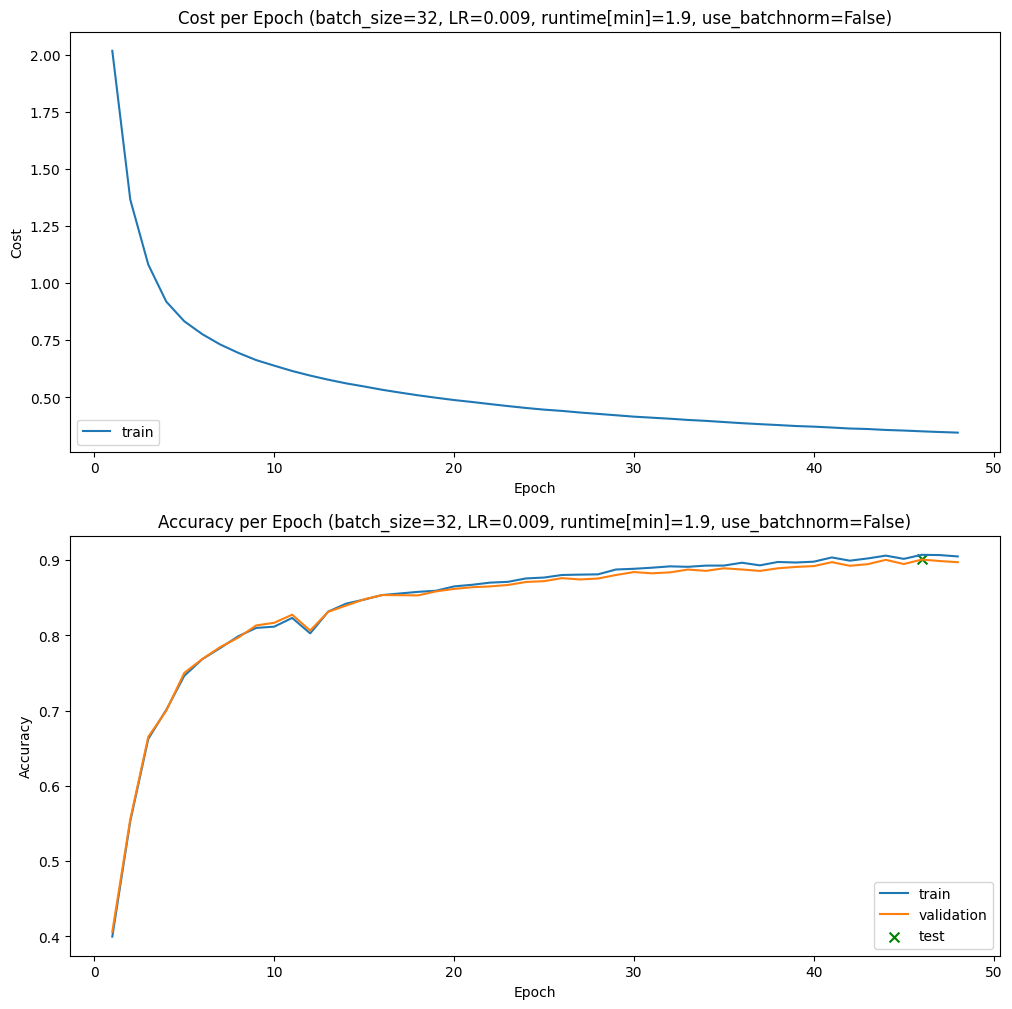

In [ ]:
fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(2, 1, 1)
plot_results('cost', metrics, 'Cost per Epoch', 'Epoch', 'Cost', batch_size, use_batchnorm, learning_rate, runtime/60)

ax = fig.add_subplot(2, 1, 2)
plot_results('accuracy', metrics, 'Accuracy per Epoch', 'Epoch', 'Accuracy', batch_size, use_batchnorm, learning_rate, runtime/60)


## Experiment 2: Applying Batch Normalization

In [ ]:
learning_rate = 0.009
epochs = 300
batch_size = 32
use_batchnorm = True

parameters, metrics, runtime = L_layer_model(X_train.T, y_train, layers_dims, learning_rate, epochs, batch_size, use_batchnorm=use_batchnorm)


epoch 1
epoch 1 mean cost: 1.99,  train acc: 0.226,  validation acc: 0.225
epoch 2
epoch 2 mean cost: 1.66,  train acc: 0.282,  validation acc: 0.280
epoch 3
epoch 3 mean cost: 1.50,  train acc: 0.400,  validation acc: 0.397
epoch 4
epoch 4 mean cost: 1.39,  train acc: 0.436,  validation acc: 0.435
epoch 5
epoch 5 mean cost: 1.33,  train acc: 0.459,  validation acc: 0.460
epoch 6
epoch 6 mean cost: 1.29,  train acc: 0.464,  validation acc: 0.466
epoch 7
epoch 7 mean cost: 1.26,  train acc: 0.457,  validation acc: 0.460
epoch 8
epoch 8 mean cost: 1.24,  train acc: 0.445,  validation acc: 0.444
epoch 9
epoch 9 mean cost: 1.22,  train acc: 0.456,  validation acc: 0.458
epoch 10
epoch 10 mean cost: 1.20,  train acc: 0.450,  validation acc: 0.451
epoch 11
epoch 11 mean cost: 1.18,  train acc: 0.446,  validation acc: 0.447
epoch 12
epoch 12 mean cost: 1.15,  train acc: 0.457,  validation acc: 0.457
epoch 13
epoch 13 mean cost: 1.12,  train acc: 0.460,  validation acc: 0.462
epoch 14
epoch 14

In [ ]:
print(f"best epoch: {metrics['best_epoch']}")
acc = Predict(X_test.T, y_test, parameters)
metrics['test_acc'] = acc
print(f'test accuracy: {acc:.3f}')

best epoch: 48
test accuracy: 0.775


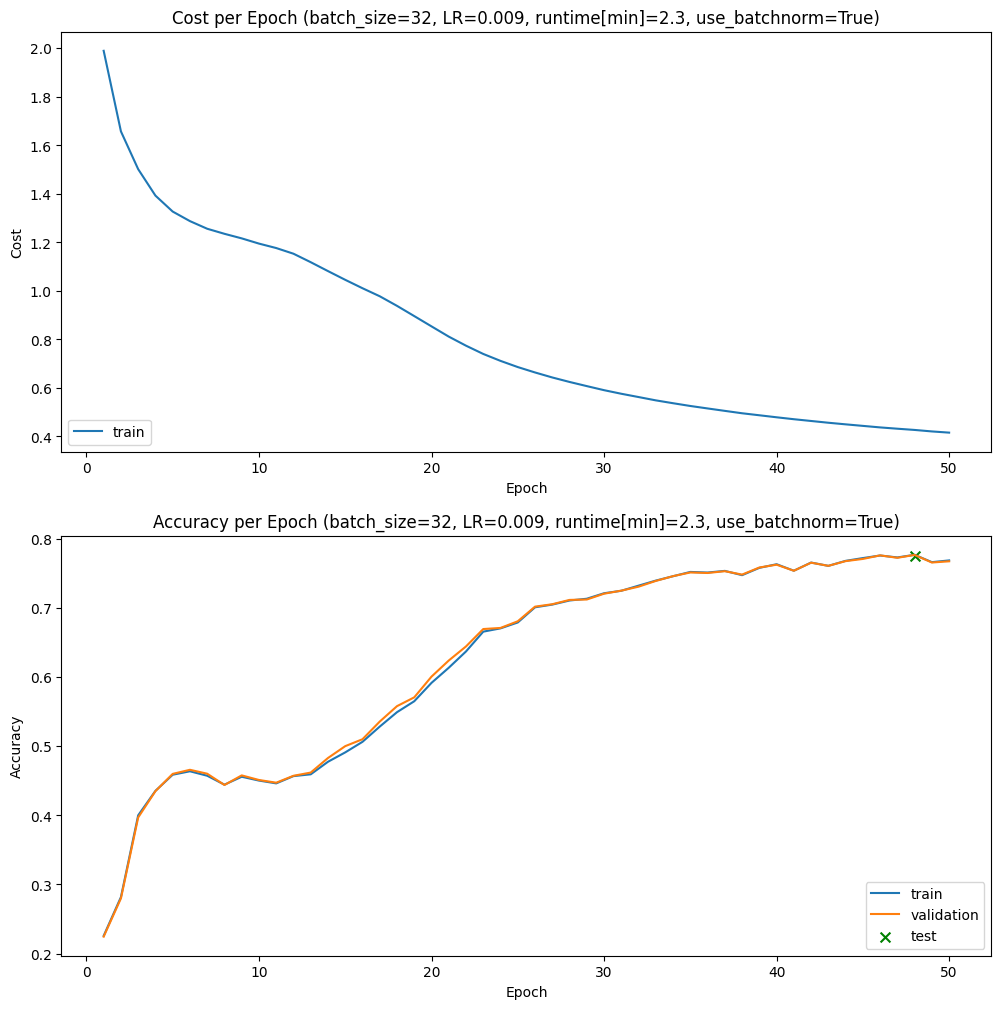

In [ ]:
fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(2, 1, 1)
plot_results('cost', metrics, 'Cost per Epoch', 'Epoch', 'Cost', batch_size, use_batchnorm, learning_rate, runtime/60)

ax = fig.add_subplot(2, 1, 2)
plot_results('accuracy', metrics, 'Accuracy per Epoch', 'Epoch', 'Accuracy', batch_size, use_batchnorm, learning_rate, runtime/60)


## Experiment 3: Dropout (Without Batch Normlization)

Test a few configuration

In [ ]:
learning_rate = 0.009
epochs = 300
batch_size = 32
use_batchnorm = False

drop_out_configurations = [[0, 0, 0.1],[0, 0 ,0.2],[0, 0, 0.3],[0, 0, 0.4],[0, 0, 0.5],
                           [0, 0.1, 0],[0, 0.2 ,0],[0, 0.3, 0],[0, 0.4, 0],[0, 0.5, 0],
                           [0.1, 0, 0],[0.2 ,0, 0],[0.3, 0, 0],[0.4, 0, 0],[0.5, 0, 0],
                           [0.1]*3,[0.2]*3,[0.3]*3,[0.4]*3,[0.5]*3 ]
                           
                           
for layers_dropout in drop_out_configurations:
  # run silently
  parameters, metrics, runtime = L_layer_model(X_train.T, y_train, layers_dims, learning_rate, epochs, batch_size, use_batchnorm=use_batchnorm, layers_dropout=layers_dropout)

  acc = Predict(X_test.T, y_test, parameters)
  print(f"{layers_dropout}: best epoch: {metrics['best_epoch']}, test accuracy: {acc:.3f}")
  


[0, 0, 0.1]: best epoch: 43, test accuracy: 0.856
[0, 0, 0.2]: best epoch: 36, test accuracy: 0.749
[0, 0, 0.3]: best epoch: 27, test accuracy: 0.585
[0, 0, 0.4]: best epoch: 34, test accuracy: 0.541
[0, 0, 0.5]: best epoch: 12, test accuracy: 0.412
[0, 0.1, 0]: best epoch: 77, test accuracy: 0.905
[0, 0.2, 0]: best epoch: 29, test accuracy: 0.839
[0, 0.3, 0]: best epoch: 37, test accuracy: 0.740
[0, 0.4, 0]: best epoch: 34, test accuracy: 0.702
[0, 0.5, 0]: best epoch: 22, test accuracy: 0.592
[0.1, 0, 0]: best epoch: 42, test accuracy: 0.901
[0.2, 0, 0]: best epoch: 43, test accuracy: 0.886
[0.3, 0, 0]: best epoch: 43, test accuracy: 0.854
[0.4, 0, 0]: best epoch: 59, test accuracy: 0.844
[0.5, 0, 0]: best epoch: 57, test accuracy: 0.810
[0.1, 0.1, 0.1]: best epoch: 56, test accuracy: 0.879
[0.2, 0.2, 0.2]: best epoch: 52, test accuracy: 0.777
[0.3, 0.3, 0.3]: best epoch: 35, test accuracy: 0.610
[0.4, 0.4, 0.4]: best epoch: 39, test accuracy: 0.433
[0.5, 0.5, 0.5]: best epoch: 14, t

Full printed run with the winning configuration

In [ ]:
layers_dropout = [0, 0.1, 0]
parameters, metrics, runtime = L_layer_model(X_train.T, y_train, layers_dims, learning_rate, epochs, batch_size, use_batchnorm=use_batchnorm, layers_dropout=layers_dropout)

print(f"best epoch: {metrics['best_epoch']}")
acc = Predict(X_test.T, y_test, parameters)
metrics['test_acc'] = acc
print(f'test accuracy: {acc:.3f}')

epoch 1
epoch 1 mean cost: 2.15,  train acc: 0.287,  validation acc: 0.289
epoch 2
epoch 2 mean cost: 1.77,  train acc: 0.483,  validation acc: 0.485
epoch 3
epoch 3 mean cost: 1.44,  train acc: 0.578,  validation acc: 0.578
epoch 4
epoch 4 mean cost: 1.27,  train acc: 0.621,  validation acc: 0.626
epoch 5
epoch 5 mean cost: 1.19,  train acc: 0.647,  validation acc: 0.653
epoch 6
epoch 6 mean cost: 1.14,  train acc: 0.687,  validation acc: 0.692
epoch 7
epoch 7 mean cost: 1.10,  train acc: 0.713,  validation acc: 0.716
epoch 8
epoch 8 mean cost: 1.06,  train acc: 0.730,  validation acc: 0.731
epoch 9
epoch 9 mean cost: 1.02,  train acc: 0.746,  validation acc: 0.748
epoch 10
epoch 10 mean cost: 0.98,  train acc: 0.759,  validation acc: 0.761
epoch 11
epoch 11 mean cost: 0.94,  train acc: 0.772,  validation acc: 0.773
epoch 12
epoch 12 mean cost: 0.92,  train acc: 0.785,  validation acc: 0.783
epoch 13
epoch 13 mean cost: 0.91,  train acc: 0.804,  validation acc: 0.805
epoch 14
epoch 14

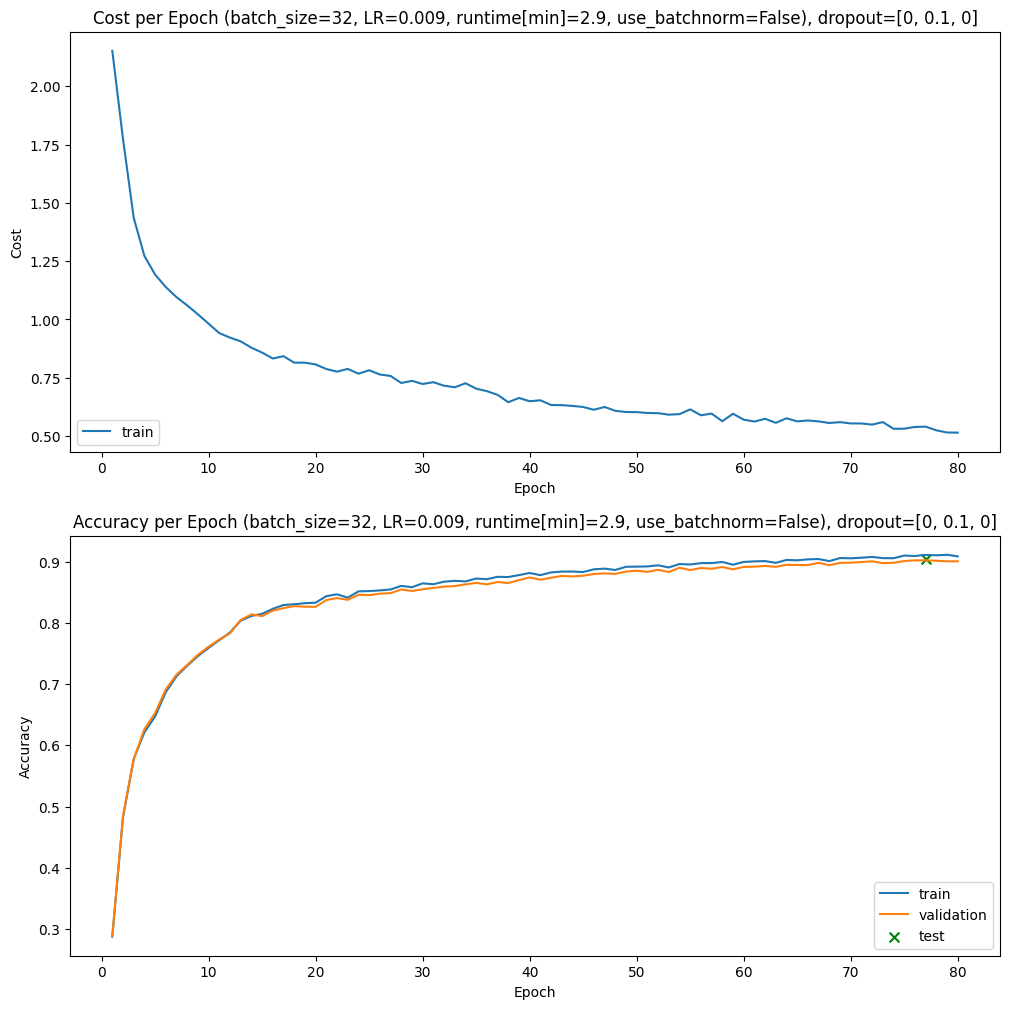

In [ ]:
fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(2, 1, 1)
plot_results('cost', metrics, 'Cost per Epoch', 'Epoch', 'Cost', batch_size, use_batchnorm, learning_rate, runtime/60, layers_dropout)

ax = fig.add_subplot(2, 1, 2)
plot_results('accuracy', metrics, 'Accuracy per Epoch', 'Epoch', 'Accuracy', batch_size, use_batchnorm, learning_rate, runtime/60, layers_dropout)


## Experiment 4: Dropout + Batch Normlization

In [ ]:
learning_rate = 0.009
epochs = 300
batch_size = 32
use_batchnorm = True
layers_dropout = [0, 0.1, 0]

parameters, metrics, runtime = L_layer_model(X_train.T, y_train, layers_dims, learning_rate, epochs, batch_size, use_batchnorm=use_batchnorm, layers_dropout=layers_dropout)

print(f"best epoch: {metrics['best_epoch']}")
acc = Predict(X_test.T, y_test, parameters)
metrics['test_acc'] = acc
print(f'test accuracy: {acc:.3f}')


epoch 1
epoch 1 mean cost: 2.10,  train acc: 0.227,  validation acc: 0.228
epoch 2
epoch 2 mean cost: 1.83,  train acc: 0.267,  validation acc: 0.265
epoch 3
epoch 3 mean cost: 1.73,  train acc: 0.347,  validation acc: 0.343
epoch 4
epoch 4 mean cost: 1.64,  train acc: 0.416,  validation acc: 0.417
epoch 5
epoch 5 mean cost: 1.55,  train acc: 0.449,  validation acc: 0.450
epoch 6
epoch 6 mean cost: 1.51,  train acc: 0.487,  validation acc: 0.490
epoch 7
epoch 7 mean cost: 1.48,  train acc: 0.512,  validation acc: 0.516
epoch 8
epoch 8 mean cost: 1.46,  train acc: 0.526,  validation acc: 0.528
epoch 9
epoch 9 mean cost: 1.44,  train acc: 0.533,  validation acc: 0.536
epoch 10
epoch 10 mean cost: 1.41,  train acc: 0.539,  validation acc: 0.543
epoch 11
epoch 11 mean cost: 1.39,  train acc: 0.542,  validation acc: 0.546
epoch 12
epoch 12 mean cost: 1.38,  train acc: 0.551,  validation acc: 0.555
epoch 13
epoch 13 mean cost: 1.38,  train acc: 0.589,  validation acc: 0.591
epoch 14
epoch 14

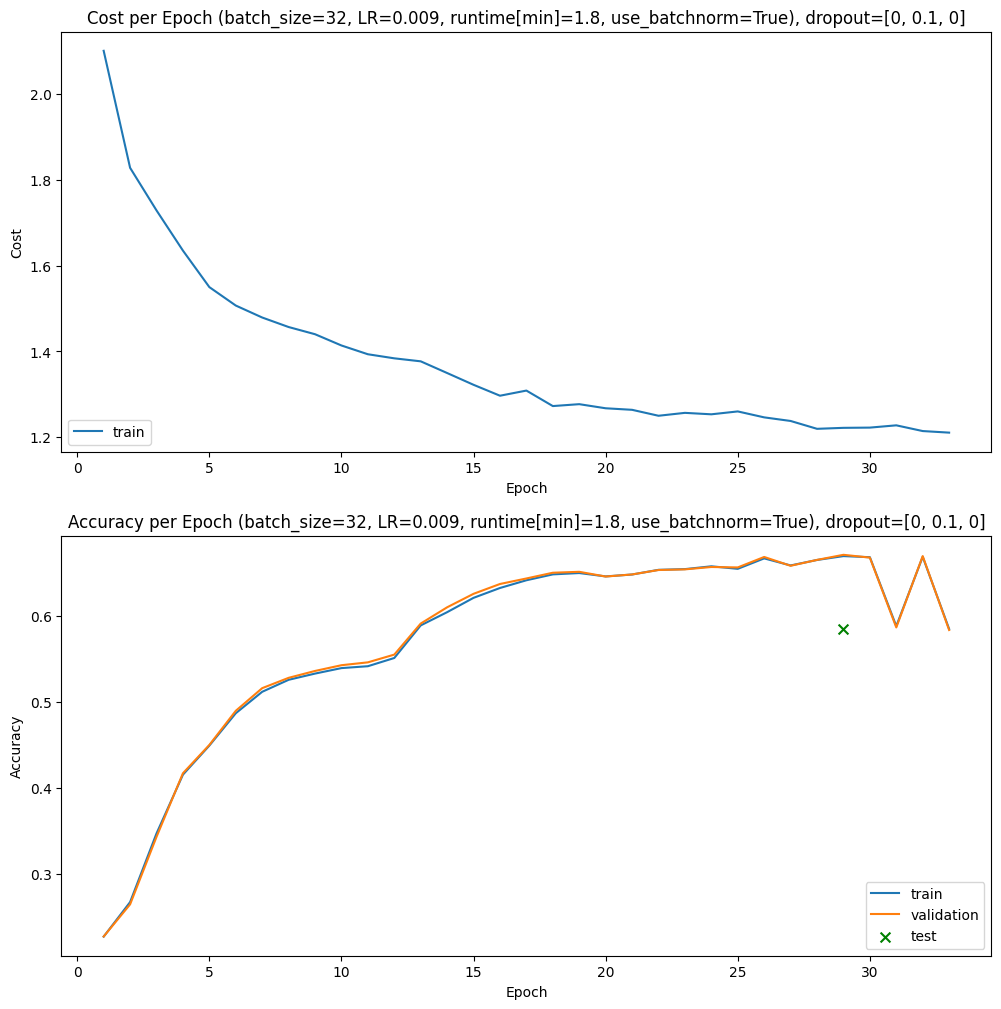

In [ ]:
fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(2, 1, 1)
plot_results('cost', metrics, 'Cost per Epoch', 'Epoch', 'Cost', batch_size, use_batchnorm, learning_rate, runtime/60, layers_dropout)

ax = fig.add_subplot(2, 1, 2)
plot_results('accuracy', metrics, 'Accuracy per Epoch', 'Epoch', 'Accuracy', batch_size, use_batchnorm, learning_rate, runtime/60, layers_dropout)


## Repeat Experiment 1 With Larger Batch Size + Hyperparameter Tuning

To run this experiment:
* set batch size to 1024
* set learning rate to 0.025
* increased the number of epochs to 700
* omitted the stopping criteria

This is to show that larger batches are possible if we change the learning rate.

In [ ]:
learning_rate = 0.025
epochs = 700
batch_size = 1024
use_batchnorm = False

parameters, metrics, runtime = L_layer_model(X_train.T, y_train, layers_dims, learning_rate, epochs, batch_size, use_batchnorm=use_batchnorm)


100 patience!=4
epoch 1
epoch 1 mean cost: 2.49,  train acc: 0.098,  validation acc: 0.101
epoch 2
epoch 2 mean cost: 2.24,  train acc: 0.153,  validation acc: 0.158
epoch 3
epoch 3 mean cost: 2.18,  train acc: 0.191,  validation acc: 0.194
epoch 4
epoch 4 mean cost: 2.12,  train acc: 0.209,  validation acc: 0.211
epoch 5
epoch 5 mean cost: 2.07,  train acc: 0.225,  validation acc: 0.227
epoch 6
epoch 6 mean cost: 2.02,  train acc: 0.241,  validation acc: 0.243
epoch 7
epoch 7 mean cost: 1.96,  train acc: 0.275,  validation acc: 0.278
epoch 8
epoch 8 mean cost: 1.91,  train acc: 0.282,  validation acc: 0.288
epoch 9
epoch 9 mean cost: 1.85,  train acc: 0.298,  validation acc: 0.301
epoch 10
epoch 10 mean cost: 1.78,  train acc: 0.334,  validation acc: 0.343
epoch 11
epoch 11 mean cost: 1.71,  train acc: 0.381,  validation acc: 0.388
epoch 12
epoch 12 mean cost: 1.63,  train acc: 0.410,  validation acc: 0.415
epoch 13
epoch 13 mean cost: 1.55,  train acc: 0.431,  validation acc: 0.435
e

In [ ]:
print(f"best epoch: {metrics['best_epoch']}")
acc = Predict(X_test.T, y_test, parameters)
metrics['test_acc'] = acc
print(f'test accuracy: {acc:.3f}')

best epoch: 699
test accuracy: 0.909


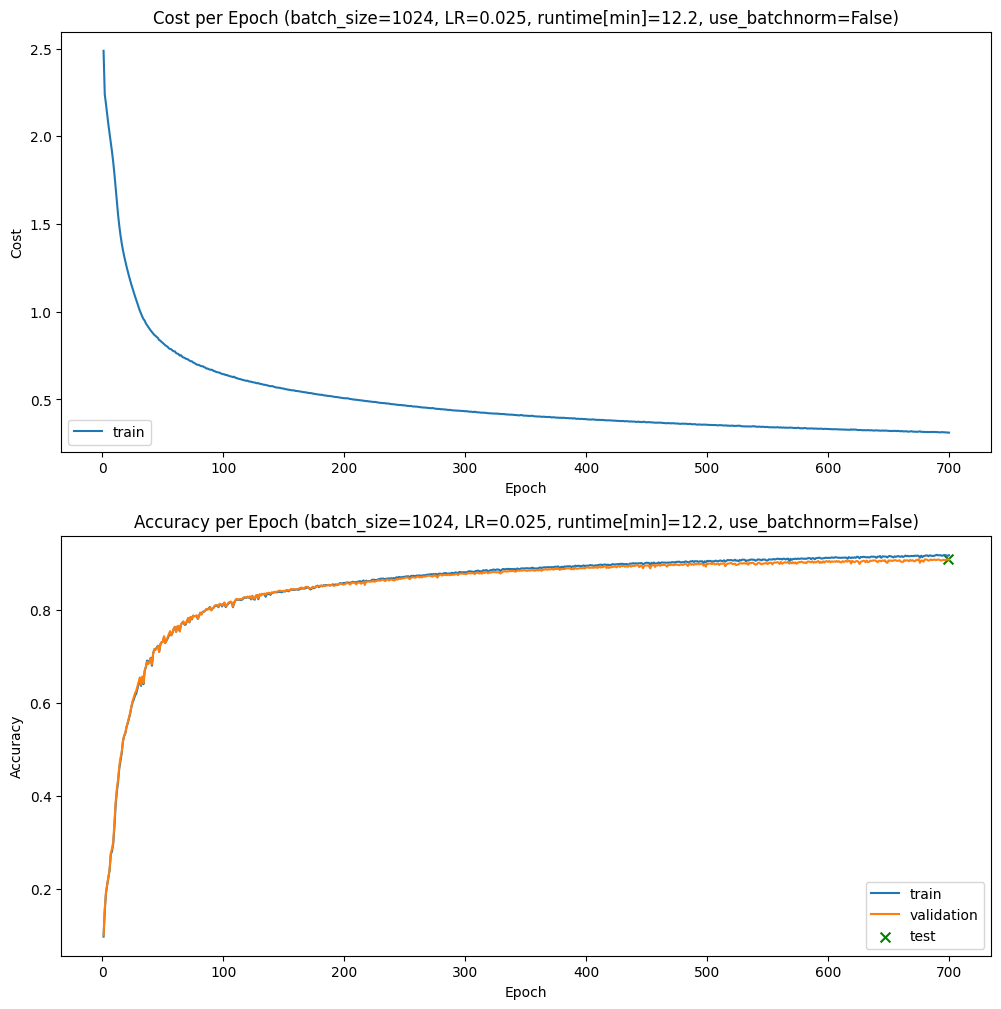

In [ ]:
fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(2, 1, 1)

plot_results('cost', metrics, 'Cost per Epoch', 'Epoch', 'Cost', batch_size, use_batchnorm , learning_rate, runtime/60)

ax = fig.add_subplot(2, 1, 2)
plot_results('accuracy', metrics, 'Accuracy per Epoch', 'Epoch', 'Accuracy', batch_size, use_batchnorm, learning_rate, runtime/60)


## Repeat Experiment 1 With Different Batch Sizes

In [ ]:
learning_rate = 0.009
epochs = 300
batch_size = 32
use_batchnorm = False

batch_size_configurations = [2**i for i in range(2,11)]
                           
                           
for batch_size in batch_size_configurations:
  # run silently
  parameters, metrics, runtime = L_layer_model(X_train.T, y_train, layers_dims, learning_rate, epochs, batch_size, use_batchnorm=use_batchnorm)

  acc = Predict(X_test.T, y_test, parameters)
  print(f"batch_size {batch_size}: best epoch: {metrics['best_epoch']}, test accuracy: {acc:.3f}, runtime: {(runtime/60):.3f} minutes")
  


batch_size 4: best epoch: 21, test accuracy: 0.935, runtime: 2.783 minutes
batch_size 8: best epoch: 30, test accuracy: 0.923, runtime: 2.167 minutes
batch_size 16: best epoch: 28, test accuracy: 0.901, runtime: 1.100 minutes
batch_size 32: best epoch: 46, test accuracy: 0.902, runtime: 1.867 minutes
batch_size 64: best epoch: 75, test accuracy: 0.895, runtime: 2.100 minutes
batch_size 128: best epoch: 96, test accuracy: 0.875, runtime: 2.200 minutes
batch_size 256: best epoch: 91, test accuracy: 0.832, runtime: 1.983 minutes
batch_size 512: best epoch: 109, test accuracy: 0.792, runtime: 2.400 minutes
batch_size 1024: best epoch: 184, test accuracy: 0.773, runtime: 3.683 minutes
